In [111]:
import numpy as np
import pandas as pd
df = pd.read_csv("../data/processed/transactions.csv")

In [112]:
df.head()

,customer_id,total_spent,avg_order_value,total_orders,total_items,avg_discount,avg_review_rating,avg_seller_rating,avg_delivery_days,total_returns,return_ratio,total_previous_returns,is_prime_member,customer_tenure_days,last_order_date,first_order_date,recency_days,tenure_days,frequency
0,C10000,58.88,29.440,2,2,0.005,5.0,4.145,1.0,0,0.0,1,1,2397,2025-08-06 14:00:00,2024-05-19 18:00:00,17,443,0.135440
1,C10004,118.49,59.245,2,2,0.000,1.0,4.290,4.0,1,0.5,0,1,3440,2024-09-19 17:00:00,2024-06-02 06:00:00,338,109,0.550459
2,C10005,30.46,15.230,2,2,0.005,5.0,4.160,5.0,0,0.0,0,1,2572,2025-07-26 02:00:00,2025-03-01 20:00:00,28,146,0.410959
3,C10006,0.00,0.000,1,1,0.010,4.0,4.210,4.0,1,1.0,1,1,2469,2025-05-02 00:00:00,2025-05-02 00:00:00,113,1,30.000000
4,C10007,154.50,154.500,1,1,0.000,3.0,3.360,3.0,0,0.0,0,0,1618,2024-06-13 02:00:00,2024-06-13 02:00:00,436,1,30.000000


In [113]:
# quick check ( everything is processed )
print("=== SHAPE ===")
print(df.shape)
print("\n=== COLUMNS ===")
print(list(df.columns))
print("\n=== DTYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES PER COLUMN ===")
print(df.isna().sum())

=== SHAPE ===
(2447, 19)

=== COLUMNS ===
['customer_id', 'total_spent', 'avg_order_value', 'total_orders', 'total_items', 'avg_discount', 'avg_review_rating', 'avg_seller_rating', 'avg_delivery_days', 'total_returns', 'return_ratio', 'total_previous_returns', 'is_prime_member', 'customer_tenure_days', 'last_order_date', 'first_order_date', 'recency_days', 'tenure_days', 'frequency']

=== DTYPES ===
customer_id                object
total_spent               float64
avg_order_value           float64
total_orders                int64
total_items                 int64
avg_discount              float64
avg_review_rating         float64
avg_seller_rating         float64
avg_delivery_days         float64
total_returns               int64
return_ratio              float64
total_previous_returns      int64
is_prime_member             int64
customer_tenure_days        int64
last_order_date            object
first_order_date           object
recency_days                int64
tenure_days        

#### Heuristic target engineering

In [114]:
# creating a synthetic target
df['clv'] = (
    (df['total_spent'] * 0.6) +
    (df['avg_order_value'] * df['frequency'] * 0.3) +
    (df['customer_tenure_days'] * 0.2) -
    (df['return_ratio'] * 100) +
    (df['is_prime_member'] * 150)
)

In [115]:
# Drop non-numeric / irrelevant columns
X = df.drop(columns=['clv', 'customer_id', 'first_order_date', 'last_order_date'], errors='ignore')
y = df['clv']

In [116]:
df[['customer_id', 'clv']].head()

,customer_id,clv
0,C10000,665.924208
1,C10004,868.877578
2,C10005,684.553671
3,C10006,543.800000
4,C10007,1806.800000


In [117]:
from sklearn.model_selection import train_test_split
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
from sklearn.preprocessing import StandardScaler
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [119]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Random Forest

In [120]:
rfr = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rfr.fit(X_train_scaled, y_train)

# evaluate
y_pred_rf = rfr.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n📊 Random forest Results:")
print("MAE:", round(mae_rf, 2))
print("R² :", round(r2_rf, 3))



📊 Random forest Results:
MAE: 46.34
R² : 0.969


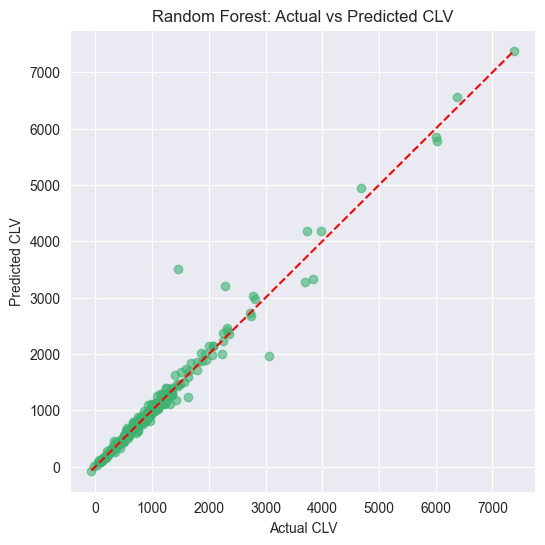

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Random Forest: Actual vs Predicted CLV")
plt.show()


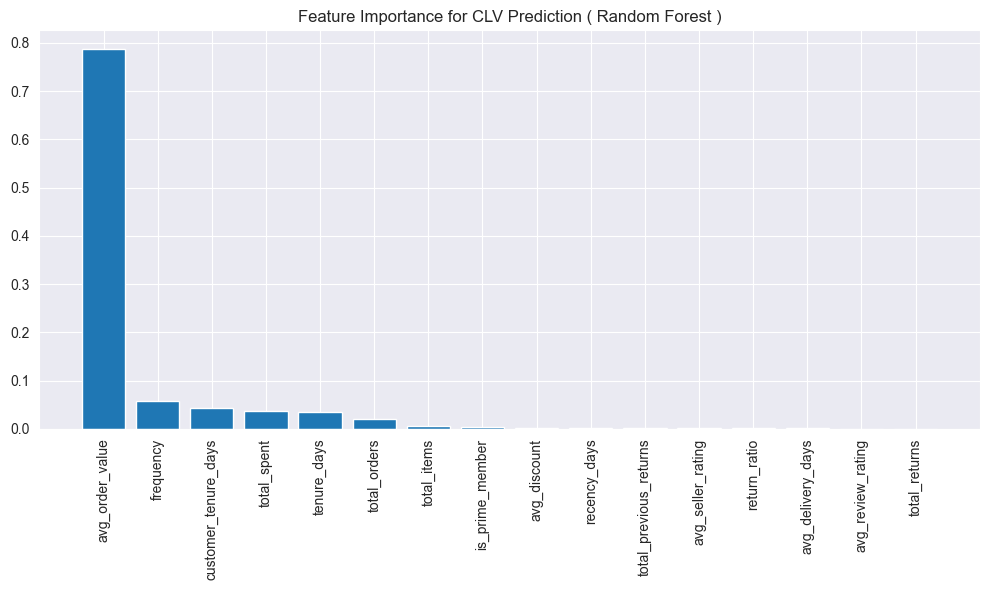

In [122]:
import matplotlib.pyplot as plt
import numpy as np

importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance for CLV Prediction ( Random Forest )")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


# LightGBM

In [123]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
# LightGBM Model
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train_scaled, y_train)

# evaluate
y_pred_lgb = lgb_model.predict(X_test_scaled)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\n📊 LightGBM Results:")
print("MAE:", round(mae_lgb, 2))
print("R² :", round(r2_lgb, 3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 1957, number of used features: 16
[LightGBM] [Info] Start training from score 900.660311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

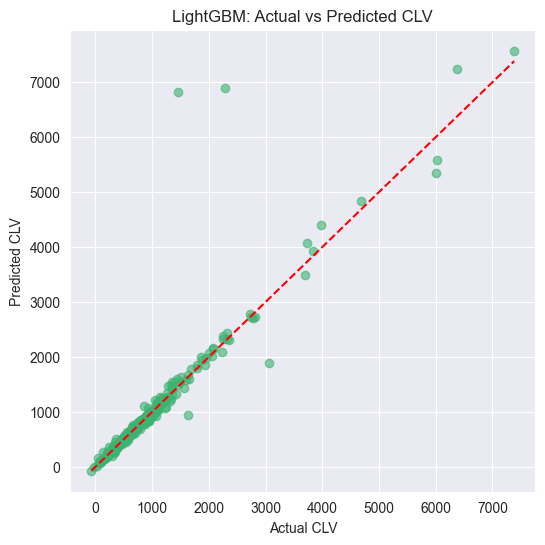

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lgb, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("LightGBM: Actual vs Predicted CLV")
plt.show()


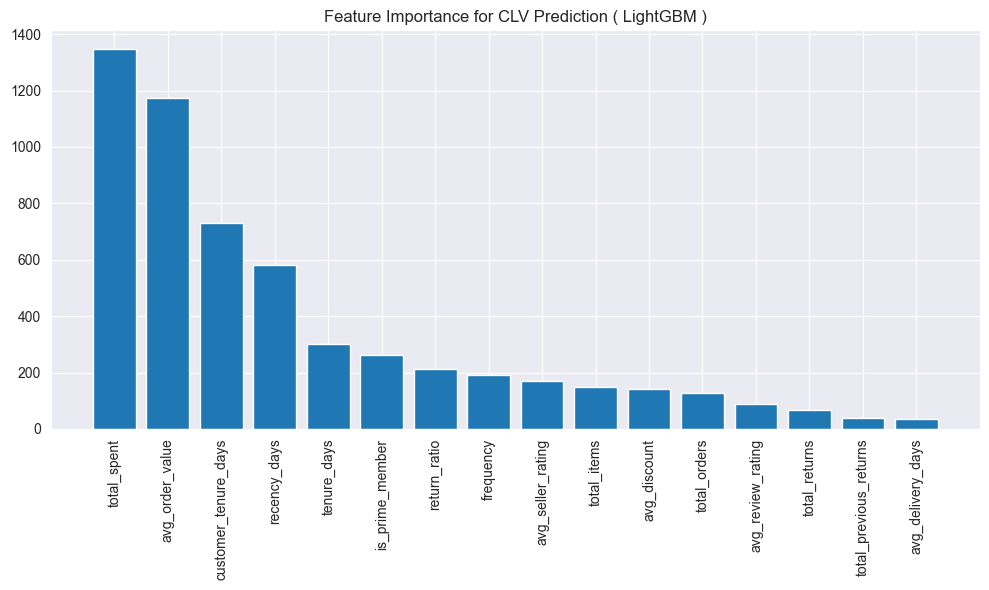

In [125]:
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance for CLV Prediction ( LightGBM )")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


# XGBoost

In [126]:
# XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n📊 XGBoost Results:")
print("MAE:", round(mae_xgb, 2))
print("R² :", round(r2_xgb, 3))


📊 XGBoost Results:
MAE: 25.06
R² : 0.99


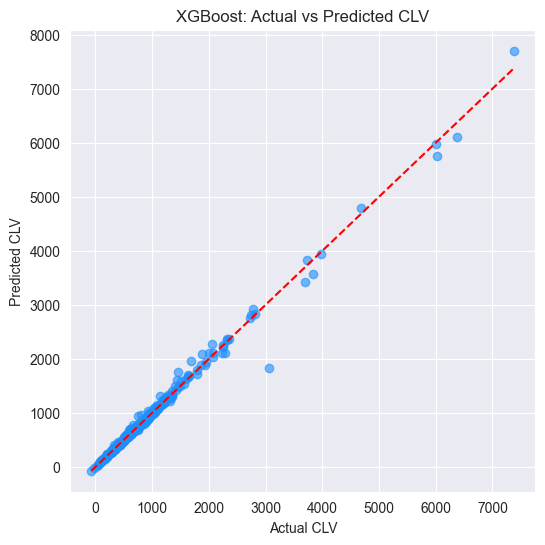

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("XGBoost: Actual vs Predicted CLV")
plt.show()

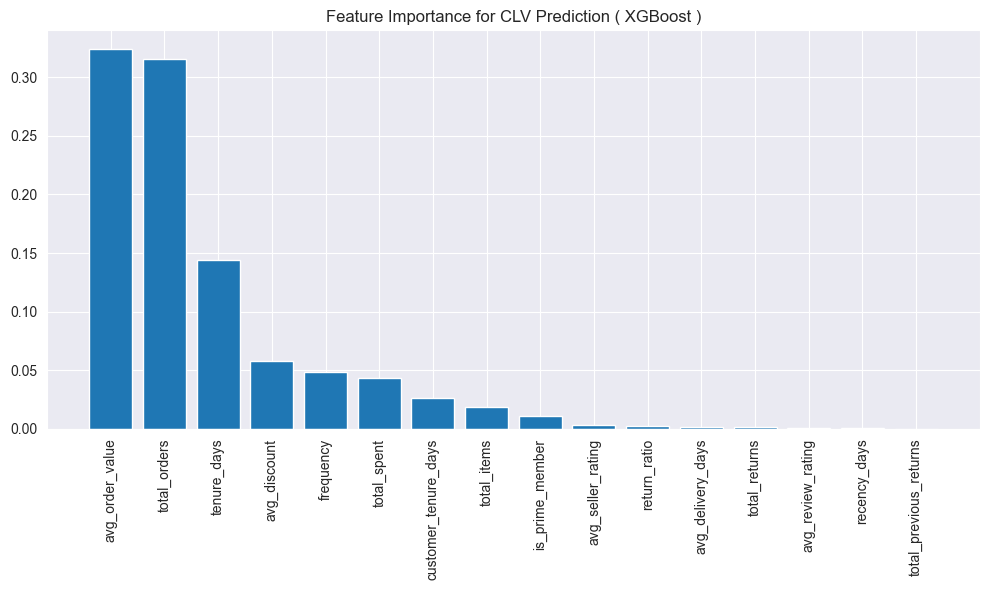

In [128]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance for CLV Prediction ( XGBoost )")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


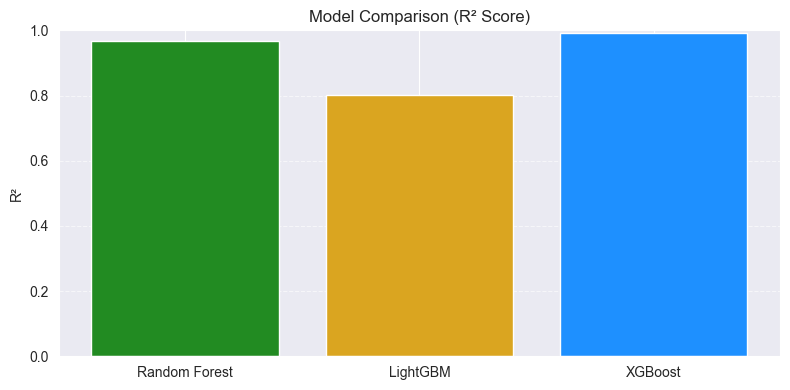

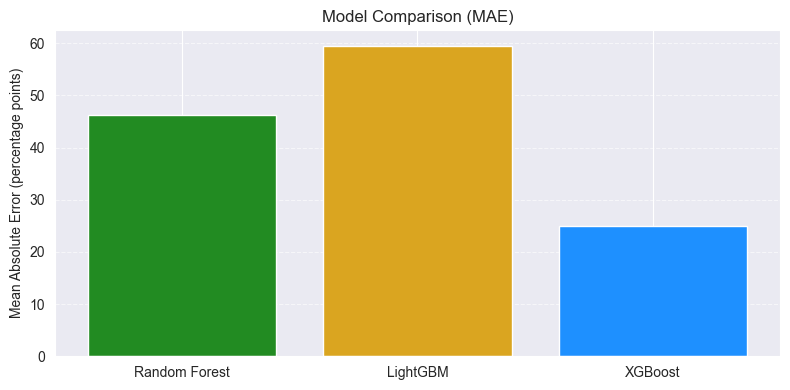

In [129]:
# STEP 8 — Compare R² and MAE for the three models
# ------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

# replace with your real results
# (edit with the numbers you obtained)
results = pd.DataFrame([
    ["Random Forest", mae_rf, r2_rf],
    ["LightGBM", mae_lgb, r2_lgb],
    ["XGBoost", mae_xgb, r2_xgb]
], columns=["Model", "MAE", "R²"])

# --- R² plot ---
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["R²"], color=["forestgreen","goldenrod","dodgerblue"])
plt.title("Model Comparison (R² Score)")
plt.ylabel("R²")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- MAE plot ---
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["MAE"], color=["forestgreen","goldenrod","dodgerblue"])
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error (percentage points)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# XGBoost gives the lowest MAE and highest R² → it predicts customer life time value with the highest precision and consistency.

In [130]:
import joblib

# Save model to file
joblib.dump(xgb_model, "../model/xgb_model.pkl")

print("✅ Model saved as xgb_model.pkl")

✅ Model saved as xgb_model.pkl
